# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from dirrac.classifier.logistic import logistic_classifier, logistic_visualize
from dirrac.data.synthetic_data import DataSynthesizer
from dirrac.gen_counterfactual import DRRA
from ar.gen_counterfactual import LinearAR
from mace.loadModel import loadModelForDataset
from mace.batchTest import runExperiments
from utils import pad_ones, cal_validity

[ENV WARNING] deactivate virtualenv to allow for testing Actionable Recourse


In [2]:
if not os.path.exists('result/figure3/'):
    os.makedirs('result/figure3/')

In [203]:
# Matplotlib config
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE - 2)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

# Synthesize data and train original classifier

In [125]:
# Synthesize data 
mean_0 = np.ones(2) * (-3)
mean_1 = np.ones(2) * 3
cov_0 = cov_1 = np.identity(2)
n = 1000
p = [0.3, 0.4, 0.3]

sd = DataSynthesizer(mean_0, cov_0, mean_1, cov_1, n)
features, labels = sd.synthesize_modes_data(100, [0.3, 0.4, 0.3], [0.1, 0.1])

In [126]:
# Train 101 logistic classifiers - the first classifier is on original data, other
all_coef = np.zeros((101, 3))
for i in range(101):
    coef = logistic_classifier(pad_ones(features[i]), labels[i])[1].T
    all_coef[i] = np.squeeze(coef)

# Get theta
mean_shift = all_coef[1:31]
cov_shift = all_coef[31:71]
both_shift = all_coef[71:101]

theta = np.zeros((3, 3))
sigma = np.zeros((3, 3, 3))

theta[0], sigma[0] = np.mean(mean_shift, axis=0), np.cov(mean_shift.T)
theta[1], sigma[1] = np.mean(cov_shift, axis=0), np.cov(cov_shift.T)
theta[2], sigma[2] = np.mean(both_shift, axis=0), np.cov(both_shift.T)

# Save to csv

In [5]:
df = pd.DataFrame(columns=['label', 'x0', 'x1'])
df['label'] = labels[0]
df['x0'] = features[0][:, 0]
df['x1'] = features[0][:, 1]
df.to_csv('mace/_data_main/processed_data/synthetic_data.csv', index=False)

In [6]:
df

,label,x0,x1
0,0.0,-2.776021,-2.255409
1,0.0,-3.334269,-1.610828
2,0.0,-5.296095,-1.858795
3,0.0,-2.944552,-3.082760
4,0.0,-3.651688,-3.016022
...,...,...,...
995,1.0,1.891151,4.456270
996,1.0,1.099763,4.243181
997,1.0,2.240315,3.742204
998,1.0,3.128713,2.557857


In [7]:
# Train the original classifier and get the instances that are classified as negative class
model_trained, X_train, y_train, X_test, y_test = loadModelForDataset('lr', 'synthetic')
X_recourse = X_test[model_trained.predict(X_test) == 0]

# Initialization

In [8]:
# DDRA 
delta = 0.2
k = 3
dim = 3
rho = np.array([0, 0, 0])
lmbda = 0.7
zeta = 1

drra_module = DRRA(delta, k, dim, p, theta, sigma, rho, lmbda, zeta, padding=True)
ar_module = LinearAR(X_train, model_trained.coef_, model_trained.intercept_)

# Generate counterfactual

In [9]:
print("Generate counterfactual for DiRRAc")
counterfactual_drra_nm = drra_module.fit_data(pad_ones(X_recourse), model='nm')
print("Generate counterfactual for Gaussian DiRRAc")
counterfactual_drra_gm = drra_module.fit_data(pad_ones(X_recourse), model='gm')
print("Generate counterfactual for AR")
counterfactual_ar = ar_module.fit_data(X_recourse)
print("Generate counterfactual for MACE")
counterfactual_mace = runExperiments(['synthetic'], ['lr'], ['one_norm'], ['MACE_eps_1e-5'], 0, len(X_recourse), 'neg_only', '0')

Generate counterfactual for DiRRAc
Generate counterfactual for Gaussian DiRRAc
Generate counterfactual for AR
Generate counterfactual for MACE


In [11]:
# Define shift params
alpha_l = [0.1 * i for i in range(11)]
beta_l = [0.1 * i for i in range(11)]

def run_experiments(shift_type='mean'):
    """ Run experiments for 3 types of data distribution shifts """
    # Init
    validity_drra_nm, std_drra_nm = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_drra_gm, std_drra_gm = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_ar, std_ar = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))
    validity_mace, std_mace = np.zeros(len(alpha_l)), np.zeros(len(alpha_l))

    for i in range(1, len(alpha_l)):      
        
        mean_shift = mean_0 + [alpha_l[i], 0] if shift_type in ['mean', 'both'] else mean_0
        cov_shift = cov_0 * (1 + beta_l[i]) if shift_type in ['cov', 'both'] else cov_0
        
        iter_drra_nm = np.zeros(100)
        iter_drra_gm = np.zeros(100)
        iter_ar = np.zeros(100)
        iter_mace = np.zeros(100)
        features, labels = sd.synthesize_data(mean_shift, cov_shift, mean_1, cov_1)
        for j in range(100):
            features, labels = sd.synthesize_data(mean_shift, cov_shift, mean_1, cov_1)
            clf_shift, coef_shift = logistic_classifier(features, labels)

            iter_drra_nm[j] = cal_validity(clf_shift.predict(counterfactual_drra_nm[:, :-1]))
            iter_drra_gm[j] = cal_validity(clf_shift.predict(counterfactual_drra_gm[:, :-1]))
            iter_ar[j] = cal_validity(clf_shift.predict(counterfactual_ar))
            iter_mace[j] = cal_validity(clf_shift.predict(counterfactual_mace))
        
        validity_drra_nm[i], std_drra_nm[i] = np.mean(iter_drra_nm), np.std(iter_drra_nm)
        validity_drra_gm[i], std_drra_gm[i] = np.mean(iter_drra_gm), np.std(iter_drra_gm)
        validity_ar[i], std_ar[i] = np.mean(iter_ar), np.std(iter_ar)
        validity_mace[i], std_mace[i] = np.mean(iter_mace), np.std(iter_mace)

    # Validity for original data
    validity_drra_nm[0] = cal_validity(model_trained.predict(counterfactual_drra_nm[:, :-1]))
    validity_drra_gm[0] = cal_validity(model_trained.predict(counterfactual_drra_gm[:, :-1]))
    validity_ar[0] = cal_validity(model_trained.predict(counterfactual_ar))
    validity_mace[0] = cal_validity(model_trained.predict(counterfactual_mace))

    return validity_drra_nm, validity_drra_gm, validity_ar, validity_mace, std_drra_nm, std_drra_gm, std_ar, std_mace

# Data distribution shift

# Mean shift

In [206]:
validity_drra_nm, validity_drra_gm, validity_ar, validity_mace, std_drra_nm, std_drra_gm, std_ar, std_mace = run_experiments(shift_type='mean')

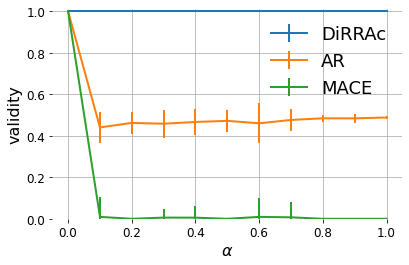

In [215]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_nm, std_drra_nm, label='DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_mace, std_mace, label='MACE')

ax.set(xlabel='$\\alpha$', ylabel='validity')
ax.grid()
ax.legend(loc='upper right', frameon=False)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/mean_shift_DiRAAc-NM.pdf', dpi=400)
plt.tight_layout()

plt.show()# Define shift params

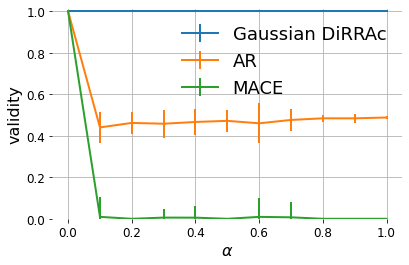

In [216]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_gm, std_drra_gm, label='Gaussian DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_mace, std_mace, label='MACE')

ax.set(xlabel='$\\alpha$', ylabel='validity')
ax.grid()
ax.legend(loc='upper right', frameon=False)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/mean_shift_DiRAAc-GM.pdf', dpi=400)
plt.tight_layout()

plt.show()

# Covariance shift

In [217]:
validity_drra_nm, validity_drra_gm, validity_ar, validity_mace, std_drra_nm, std_drra_gm, std_ar, std_mace = run_experiments(shift_type='cov')

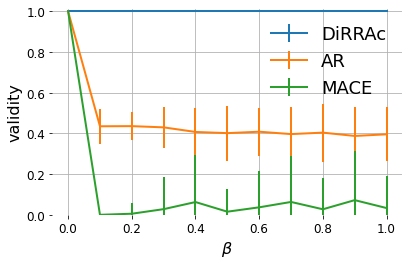

In [218]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_nm, std_drra_nm, label='DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_mace, std_mace, label='MACE')

ax.set(xlabel='$\\beta$', ylabel='validity')
ax.grid()
ax.legend(loc='upper right', frameon=False)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/covariance_shift_DiRAAc-NM.pdf', dpi=400)
plt.tight_layout()

plt.show()

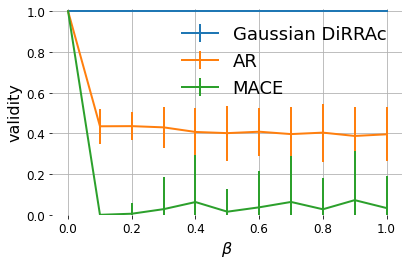

In [219]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(alpha_l, validity_drra_gm, std_drra_gm, label='Gaussian DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_mace, std_mace, label='MACE')

ax.set(xlabel='$\\beta$', ylabel='validity')
ax.grid()
ax.legend(loc='upper right', frameon=False)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/covariance_shift_DiRAAc-GM.pdf', dpi=400)
plt.tight_layout()

plt.show()

# Mean and Covariance shift

In [220]:
validity_drra_nm, validity_drra_gm, validity_ar, validity_mace, std_drra_nm, std_drra_gm, std_ar, std_mace = run_experiments(shift_type='both')

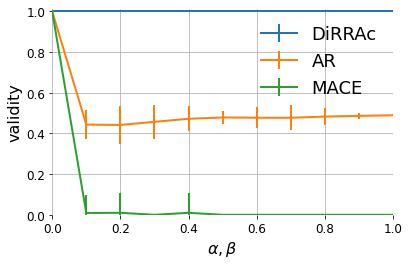

In [221]:
# Plot
ax = plt.gca()

ax.errorbar(alpha_l, validity_drra_nm, std_drra_nm, label='DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_mace, std_mace, label='MACE')

ax.set(xlabel='$\\alpha, \\beta$', ylabel='validity')
ax.grid()
ax.legend(loc='upper right', frameon=False)
ax.set_xlim(0, 1)
plt.ylim(0, 1.01)
plt.savefig('result/figure3/both_shift_DiRAAc-NM.pdf', dpi=400)
plt.tight_layout()

plt.show()

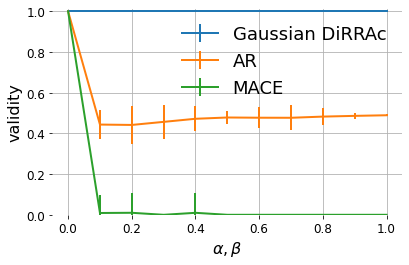

In [222]:
# Plot
ax = plt.gca()

ax.errorbar(alpha_l, validity_drra_gm, std_drra_gm, label='Gaussian DiRRAc')
ax.errorbar(alpha_l, validity_ar, std_ar, label='AR')
ax.errorbar(alpha_l, validity_mace, std_mace, label='MACE')

ax.set(xlabel='$\\alpha, \\beta$', ylabel='validity')
ax.grid()
ax.legend(loc='upper right', frameon=False)
plt.ylim(0, 1.01)
# ax.set_aspect('equal')
plt.savefig('result/figure3/both_shift_DiRAAc-GM.pdf', dpi=400)
plt.tight_layout()

plt.show()